In [308]:
from typing import Dict, List, Optional, Tuple

from pythonds3.graphs import Graph

from daup2425p2 import Delimitation, FileHandler, Point, ValidPoints


class ApproxOptimalDelimitation:
    """
    A class to calculate the approximate optimal delimitation of a set of points.
    """

    def __init__(self, valid_points: ValidPoints, max_distance: float):
        """
        Initializes the ApproxOptimalDelimitation class with a set of valid points and a maximum distance.

        Args:
            valid_points (ValidPoints): A collection of valid points.
            max_distance (float): The maximum distance between connected points.

        Complexity: O(1)
        """
        if max_distance <= 0:
            raise ValueError("Maximum distance must be positive.")
        if not isinstance(valid_points, ValidPoints):
            raise TypeError("valid_points must be of type ValidPoints.")

        self.__max_distance: float = max_distance
        self.__valid_points: ValidPoints = valid_points

    def __build_graph(self, points: List[Point]) -> Graph:
        """
        Builds a graph connecting points within the maximum distance.

        Complexity: O(N^2), where N is the number of points, due to pairwise distance checks.
        """
        graph = Graph()
        for i, point1 in enumerate(points):
            for point2 in points[i + 1 :]:
                distance = point1.distance(point2)
                if distance <= self.__max_distance:
                    graph.add_edge(point1, point2)
                    graph.add_edge(point2, point1)
        return graph

    def __get_adjacency_list(self, graph: Graph) -> Dict[Point, List[Point]]:
        """
        Generates an adjacency list where each point is connected to at least two other points within the max distance.

        Returns:
            Dict[Point, List[Point]]: A dictionary where each key is a Point, and values are lists of connected Points.

        Complexity: O(N), where N is the number of points in the graph.
        """
        adjacency_list = {}
        invalid_points = set()
        points = list(graph)

        # Remove points with less than 2 connections
        for vertex in points:
            point: Point = vertex.get_key()
            connections = [conn.get_key() for conn in vertex.get_neighbors() if conn.get_key() not in invalid_points]
            if len(connections) < 2:
                invalid_points.add(point)

        # Build adjacency list, excluding invalid points (different loops help to filter points that were only connected to invalid points)
        for vertex in [v for v in points if v not in invalid_points]:
            point: Point = vertex.get_key()
            connections = [conn.get_key() for conn in vertex.get_neighbors() if conn.get_key() not in invalid_points]
            if len(connections) > 1:
                adjacency_list[point] = connections
            else:
                invalid_points.add(point)
        return adjacency_list

    def __get_points(
        self, non_visited_points: List[Point], adjacency_data: Dict[Point, List[Point]], used_points: set
    ) -> Tuple[Optional[Point], Optional[Point]]:
        """
        Determines reference and current points based on delimitation size.

        Args:
            non_visited_points (List[Point]): List of points that have not yet been visited.
            adjacency_data (Dict[Point, List[Point]]): Adjacency list containing connections within max distance.

        Returns:
            Tuple[Optional[Point], Optional[Point]]: The reference and current points. Returns (None, None) if empty.

        Complexity: O(1), as it performs a constant-time lookup and selection operations.
        """
        if not non_visited_points:
            used_points.add(self.__start_point)
            return None, None

        if self.__delimitation.size() == 0:
            current_point = min(non_visited_points, key=lambda p: p.get_longitude())
            self.__delimitation.add_point(current_point)
            self.__start_point = current_point
            reference_point = Point("ref", current_point.get_latitude() - 1, current_point.get_longitude() - 1)
        elif self.__delimitation.size() == 1:
            _, current_point = self.__delimitation.get_last_two()
            reference_point = Point("ref", current_point.get_latitude() - 1, current_point.get_longitude() - 1)
        else:
            reference_point, current_point = self.__delimitation.get_last_two()

        if current_point not in adjacency_data:
            self.__delimitation.pop_point()
            non_visited_points.remove(current_point)
            return self.__get_points(non_visited_points, adjacency_data, used_points)

        return reference_point, current_point

    def find_delimitation(self) -> Delimitation:
        """
        Finds and returns the approximate optimal delimitation for the given set of points.

        Returns:
            Delimitation: The constructed delimitation connecting the points in an optimal manner.

        Complexity: O(N^2), where N is the number of points, due to pairwise distance checks and angle calculations.
        """
        remaining_points = self.__valid_points.get_all_points()
        max_delim = Delimitation()
        used_points = set()

        while len(remaining_points) > 3:
            # Set up points, graph, and adjacency data for the new iteration
            remaining_points, used_points, adjacency_data, non_visited_points = self._initialize_iteration(
                remaining_points, max_delim, used_points
            )

            print(remaining_points)
            # Exit if fewer than 3 points left to form a valid delimitation
            if len(adjacency_data) < 3:
                break

            # Build a single delimitation from the remaining points
            self._build_single_delimitation(adjacency_data, non_visited_points, used_points)

            # Update max_delim if the new delimitation has a larger area
            if max_delim.size() == 0 or self.__delimitation.get_area() > max_delim.get_area():
                max_delim = self.__delimitation.copy()
            else:
                used_points.update(self.__delimitation.get_points())

        return max_delim

    def _initialize_iteration(
        self, remaining_points: List[Point], max_delim: Delimitation, used_points: set
    ) -> Tuple[List[Point], set, Dict[Point, List[Point]], List[Point]]:
        """
        Prepares each iteration by updating used points, filtering remaining points, and building adjacency data.

        Args:
            remaining_points (List[Point]): Points remaining for delimitation.
            max_delim (Delimitation): The current maximum area delimitation.
            used_points (set): Set of points used in previous delimitations.

        Returns:
            Tuple containing the updated remaining points, used points, adjacency data, and non-visited points.
        Complexity:
            O(N), where N is the number of points in the valid points collection.
        """
        # Update used points
        used_points.update(
            point
            for point in self.__valid_points.get_all_points()
            if point in max_delim.get_points() or max_delim.is_point_inside(point)
        )

        # Reset delimitation and start point for the new cycle
        self.__delimitation = Delimitation()
        self.__start_point = None

        # Filter out used points from remaining points
        remaining_points = [point for point in remaining_points if point not in used_points]

        # Build graph and adjacency list for the current remaining points
        graph = self.__build_graph(remaining_points)
        adjacency_data = self.__get_adjacency_list(graph)
        non_visited_points = [point for point in remaining_points if point in adjacency_data]

        return remaining_points, used_points, adjacency_data, non_visited_points

    def _build_single_delimitation(
        self, adjacency_data: Dict[Point, List[Point]], non_visited_points: List[Point], used_points: set
    ) -> None:
        """
        Builds a single delimitation from the remaining points.

        Args:
            adjacency_data (Dict[Point, List[Point]]): Adjacency list for points within the maximum distance.
            non_visited_points (List[Point]): List of points yet to be visited in this iteration.
        Complexity:
            O(N^2), where N is the number of points in the adjacency data.
        """
        while True:
            reference_point, current_point = self.__get_points(non_visited_points, adjacency_data, used_points)
            if current_point is None:
                break

            next_point = self.__find_next_point_by_angle(
                current_point, reference_point, non_visited_points, adjacency_data
            )

            if not next_point:
                # Remove current point and backtrack if no valid next point
                self.__delimitation.pop_point()
                adjacency_data.pop(current_point, None)
                if current_point in non_visited_points:
                    non_visited_points.remove(current_point)
            else:
                # Add the next point to the delimitation
                self.__delimitation.add_point(next_point)
                non_visited_points.remove(next_point)

                # If the cycle is complete, exit the loop
                if next_point == self.__start_point:
                    break

    def __find_next_point_by_angle(
        self,
        current_point: Point,
        reference_point: Point,
        non_visited_points: List[Point],
        adjacency_data: Dict[Point, List[Point]],
        epsilon: float = 1e-1,
    ) -> Optional[Point]:
        """
        Finds the next point by calculating the forward angle between the current point and each candidate.

        Args:
            current_point (Point): The current point in the traversal.
            reference_point (Point): The reference point used to calculate angles.
            non_visited_points (List[Point]): List of candidate points to select from.
            adjacency_data (Dict[Point, List[Point]]): Adjacency list with points connected within max distance.

        Returns:
            Optional[Point]: The next point in the traversal, or None if no valid point is found.

        Complexity: O(N), where N is the number of non-visited points.
        """

        candidate_points = [
            point
            for point in non_visited_points
            if point in adjacency_data[current_point]
            and point in adjacency_data
            and not self.__delimitation.crosses_delimitation(current_point, point)
            and point != reference_point
            and point != current_point
        ]

        if not candidate_points:
            return None

        # Calculate angles for each candidate
        angles = [(point, current_point.get_forward_angle(reference_point, point)) for point in candidate_points]

        # Find the minimum angle
        min_angle = min(angles, key=lambda x: x[1])[1]

        # Filter points with angles within epsilon of the minimum angle
        nearly_colinear_points = [point for point, angle in angles if abs(angle - min_angle) <= epsilon]

        # Among nearly colinear points, choose the closest point
        return min(nearly_colinear_points, key=lambda p: current_point.distance(p))

In [325]:
fh = FileHandler("convexHullTest/file8.csv")
vp = fh.read_points()

[Point P1 (1.0, 7.0), Point P10 (0.0, 6.0), Point P11 (10.0, 7.0), Point P12 (3.0, 6.0), Point P13 (5.0, 8.0), Point P14 (7.0, 3.0), Point P15 (2.0, 1.0), Point P2 (2.0, 3.0), Point P3 (3.0, 9.0), Point P4 (5.0, 5.0), Point P5 (7.0, 2.0), Point P6 (8.0, 6.0), Point P7 (6.0, 10.0), Point P8 (4.0, 1.0), Point P9 (9.0, 4.0)]
[Point P1 (1.0, 7.0), Point P10 (0.0, 6.0), Point P11 (10.0, 7.0), Point P12 (3.0, 6.0), Point P13 (5.0, 8.0), Point P14 (7.0, 3.0), Point P3 (3.0, 9.0), Point P4 (5.0, 5.0), Point P5 (7.0, 2.0), Point P6 (8.0, 6.0), Point P7 (6.0, 10.0), Point P9 (9.0, 4.0)]
[Point P1 (1.0, 7.0), Point P10 (0.0, 6.0), Point P11 (10.0, 7.0), Point P12 (3.0, 6.0), Point P13 (5.0, 8.0), Point P3 (3.0, 9.0), Point P4 (5.0, 5.0), Point P6 (8.0, 6.0), Point P7 (6.0, 10.0)]
[Point P10 (0.0, 6.0), Point P11 (10.0, 7.0), Point P4 (5.0, 5.0), Point P6 (8.0, 6.0), Point P7 (6.0, 10.0)]


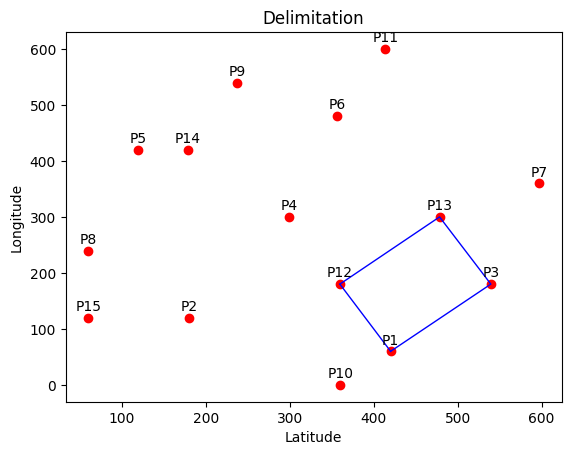

In [331]:
ap = ApproxOptimalDelimitation(vp, 175)
ap.find_delimitation().show(vp)

In [226]:
# P1  1   5
# P2  2   3
# P3  3   7
# P4  5   5
# P5  6   2
# P6  8   6
# P7  7   8
# P8  4   1
# P9  9   3


p8 = Point("P8", 4, 1)
p5 = Point("P5", 6, 2)
p2 = Point("P2", 2, 3)

print(p8.distance(p5), p8.distance(p2), p5.distance(p2))

133.59047813801564 169.3241885597168 246.24309949874723
